# Práctico Supervisado

Integrantes:

- Sofía Luján
- Lucía Benitez
- Johanna Frau

## Objetivo

Durante este práctico intentaremos predecir la velocidad en la cual una mascota es adoptada teniendo en cuenta una versión simplificada del dataset  de PetFinder (una plataforma online de bienestar animal de Malasia).

In [9]:
import os.path
if not os.path.exists("./IntroduccionAprendizajeAutomatico"):
  !git clone https://github.com/solujan/IntroduccionAprendizajeAutomatico.git

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as DT


from IntroduccionAprendizajeAutomatico.ml.visualization import plot_confusion_matrix, plot_learning_curve



## Datos

### Datos etiquetados

Para nuestra predicción contamos con tres conjuntos de datos etiquetados:

* **breed**  contiene la ID del animal, el tipo (1 para perros y 2 para gatos) y la raza.
* **color** contiene la ID del color del animal y el color respectivo.
* **state** corresponden a los estados de Malasia y sus respectivas ID.


In [0]:
breed = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/breed_labels.csv')
color = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/color_labels.csv')
state = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/state_labels.csv')

In [0]:
breed.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [0]:
color.head()


,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [0]:
state.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


### Dataset original

El conjunto original tiene la siguiente forma:



In [0]:
original_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv')
original_df.sample(5)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
5978,2,1,242,0,1,2,7,0,2,3,1,1,2,1,1,400,41326,"♥ Male, 6 weeks old, white with cream / brown ...",2,8421
4530,1,24,307,206,2,1,2,7,2,2,3,3,3,1,1,0,41401,Special needs: TLC. She is currently underweig...,2,6414
3367,2,2,266,0,3,1,4,7,2,1,2,2,2,1,4,0,41326,They are 4 lovely cute kittens. They were born...,2,4764
5123,1,36,307,0,2,1,2,0,3,1,2,2,2,1,1,0,41401,"Female dog found in Manjalara, Kepong. In good...",4,7262
3659,1,5,307,0,1,5,0,0,2,1,1,1,2,1,1,350,41336,Little Toby was abandoned by his owner. He's a...,4,5173


In [0]:
original_df.columns


Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'Description',
       'AdoptionSpeed', 'PID'],
      dtype='object')

In [0]:
original_df.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000
mean,1.454734,10.520412,265.469854,74.388868,1.779059,2.230675,3.236912,1.856738,1.860518,1.460971,1.729730,1.566528,1.912115,1.036666,1.584011,20.809960,41345.994613,2.518900,7477.025799
std,0.497970,18.374027,60.121490,123.434010,0.684763,1.743985,2.748595,2.974465,0.547535,0.593843,0.670791,0.701482,0.564041,0.198228,1.488348,78.397243,32.409109,1.176018,4310.921553
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3768.250000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7473.500000
75%,2.000000,12.000000,307.000000,188.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11200.750000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,4.000000,14992.000000


### Transformación de los datos

La siguiente función representa una transformación de los datos que reemplaza los encondings existentes en las variables por variables categoricas con el objeto hacer más fácil las visualizaciones. La misma se aplicará tanto al conjunto de entrenamiento como de evaluación.

In [0]:
def transform_data(train_data_fname, test_data_fname):
    def transform_columns(df):
        df = df.drop(["Description"], axis=1)
        df.Type = df.Type.replace({1: 'Dog', 2: 'Cat'})
        df.Gender = df.Gender.replace({1:'Male', 2:'Female', 3:'Mixed'})
        df.MaturitySize = df.MaturitySize.replace({1:'S', 2:'M', 3:'L', 4:'XL', 0:'N/A'})
        df.FurLength = df.FurLength.replace({1:'S', 2:'M', 3:'L', 0:'N/A'})
        df.Vaccinated = df.Vaccinated.replace({1:'T', 2:'N', 3:'N/A'})
        df.Dewormed = df.Dewormed.replace({1:'T', 2:'F', 3:'N/A'})
        df.Sterilized = df.Sterilized.replace({1:'T', 2:'F', 3:'N/A'})
        df.Health = df.Health.replace({1:'Healthy', 2: 'MinorInjury', 3:'SeriousInjury', 0: 'N/A'})
        df.Color1 = df.Color1.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color2 = df.Color2.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color3 = df.Color3.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Breed1 = df.Breed1.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        df.Breed2 = df.Breed2.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        return df
    
    df_train = pd.read_csv(train_data_fname)
    df_train = transform_columns(df_train)
    df_test = pd.read_csv(test_data_fname)
    df_test = transform_columns(df_test)
    
    df = pd.concat([df_train, df_test], sort=True)

    # set dummy variables for everything
    # except from Age, Quantity, Fee
    df = pd.get_dummies(df)
    # get train and test back
    n = len(df_train)
    df_train = df.iloc[:n]
    df_test = df.iloc[n:]
    
    y = df_train['AdoptionSpeed']
    X = df_train.drop('AdoptionSpeed', axis=1)
    yy = None
    XX = df_test.drop('AdoptionSpeed', axis=1)

    return X, y, XX, yy

In [0]:
X, y, XX, yy = transform_data("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv",
                              "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")


## Análisis y Visualización

La siguiente función es similar a la anterior pero tiene en cuenta todos los datos y la queremos usar para ver si encontramos alguna corelacción existente entre las variables.

In [0]:
def transform_full_data(train_data_fname, test_data_fname):
    def transform_columns(df):
        df = df.drop(["Description"], axis=1)
        df.Type = df.Type.replace({1: 'Dog', 2: 'Cat'})
        df.Gender = df.Gender.replace({1:'Male', 2:'Female', 3:'Mixed'})
        df.MaturitySize = df.MaturitySize.replace({1:'S', 2:'M', 3:'L', 4:'XL', 0:'N/A'})
        df.FurLength = df.FurLength.replace({1:'S', 2:'M', 3:'L', 0:'N/A'})
        df.Vaccinated = df.Vaccinated.replace({1:'T', 2:'N', 3:'N/A'})
        df.Dewormed = df.Dewormed.replace({1:'T', 2:'F', 3:'N/A'})
        df.Sterilized = df.Sterilized.replace({1:'T', 2:'F', 3:'N/A'})
        df.Health = df.Health.replace({1:'Healthy', 2: 'MinorInjury', 3:'SeriousInjury', 0: 'N/A'})
        df.Color1 = df.Color1.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color2 = df.Color2.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color3 = df.Color3.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Breed1 = df.Breed1.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        df.Breed2 = df.Breed2.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        return df
    
    df_full_train = pd.read_csv(train_data_fname)
    df_full_train = transform_columns(df_full_train)
    df_full_test = pd.read_csv(test_data_fname)
    df_full_test = transform_columns(df_full_test)
      
    df_full = pd.concat([df_full_train, df_full_test], sort=True)
   
    return df_full

In [0]:
df_full = transform_full_data("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv",
                              "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")
df_full.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,PID,Quantity,State,Sterilized,Type,Vaccinated
0,2.0,3,Tabby,N/A,Black,White,N/A,F,100,S,Male,Healthy,S,0,1,41326,F,Cat,N
1,2.0,4,Mixed Breed,N/A,Black,Brown,N/A,T,150,S,Female,Healthy,M,3,1,41401,F,Dog,T
2,2.0,1,Mixed Breed,N/A,Black,N/A,N/A,F,0,S,Male,Healthy,M,4,1,41326,F,Dog,N
3,2.0,3,Domestic Short Hair,N/A,Cream,Gray,N/A,F,0,S,Female,Healthy,M,5,1,41326,F,Cat,N
4,1.0,12,Domestic Long Hair,Domestic Long Hair,Black,N/A,N/A,F,300,L,Male,Healthy,M,6,1,41326,N/A,Cat,N


A continuación listamos una serie de hipótesis que creemos pueden cumplirse en una base de datos de un refugio de animales como la que estamos trabajando. Debido a que es en Malasia, es posible que algunas hipótesis no se cumplan. Por ejemplo en Argentina no se realiza la eutanasia si no consiguen familia en un cierto tiempo, lo que si sucede en Malasia con los que pasan los 100 días. Nuestras hipótesis son las siguientes:

* Estadísticamente hay mas perros que gatos en adopción. A su vez, al haber menor densidad y debido a la vida moderna, se espera que los gatos tengan mayor tasa de adopción, sobre todo en las ciudades mas grandes, como también de perros pequeños debido al espacio. 

* En las pequeñas ciudades se espera una mayor adopción de perros de mediano y gran tamaño y que haya mayor densidad de gatos en adopción (debido a la falta de conciencia en la esterilización). Además, se espera que no haya tanta demanda de adopciones, por lo que habrá una gran cantidad de animales en la última etapa de adopción.

Veamos si hay mas gatos o perros en adopción:

In [0]:
df_full['Type'].value_counts(normalize=True)

Dog    0.542386
Cat    0.457614
Name: Type, dtype: float64

De acuerdo a lo anterior observamos que el porcentaje de perros en adopción es mayor que el correspondiente a los gatos. Visualizamos esto en el siguiente gráfico.

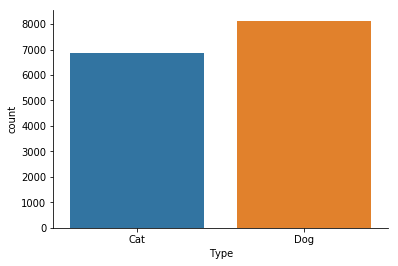

In [0]:
sns.countplot(df_full['Type'])
sns.despine()

Veremos ahora si la tasa de adopción de los gatos es mas grande que la de los perros:

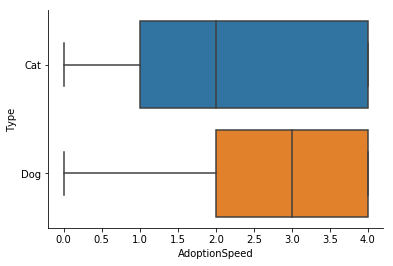

In [0]:
sns.boxplot(data=df_full,y='Type', x='AdoptionSpeed')
sns.despine()

El boxplot anterior nos muestra que la mediana de la adopción de los gatos se encuentra en 2 mientras que la de los perros se encuentra en 3. Por lo tanto los gatos tienen una mayor probabilidad de ser adoptados.

También sucede que hay mayor cantidad de animales pequeños en adopción como muestra el siguiente histograma y que a ellos los adoptan mas rápidamente (lo cual observaremos en el boxplot). Por otra parte, que sea gato favorece la adopción siendo adulto, siendo este un panorama desfavorable para los perros. Por lo tanto, se espera que los animales que estén en el último tramo de adopción, sean en su mayoría perros. 

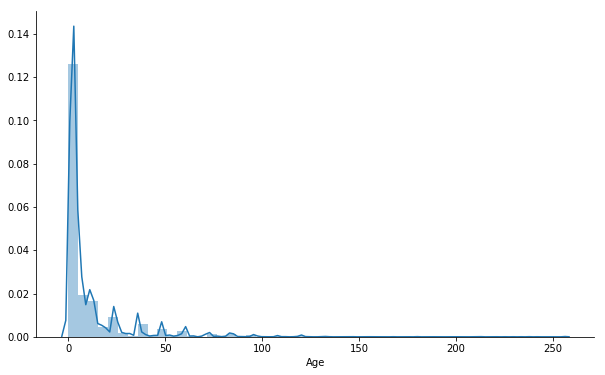

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(df_full['Age'], norm_hist=True)
sns.despine()

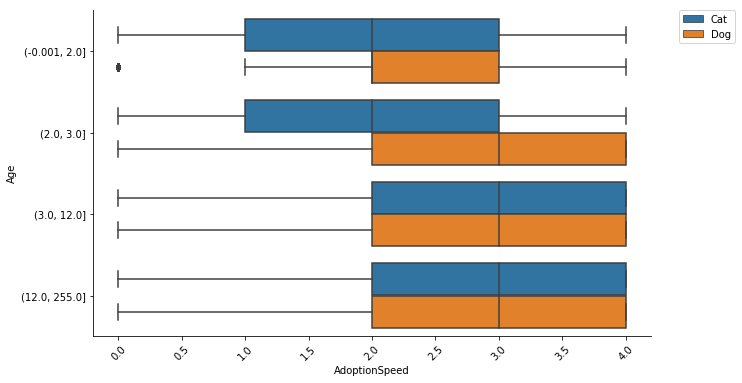

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_full,
                x='AdoptionSpeed', y=pd.qcut(df_full['Age'],4), hue='Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
sns.despine()


Podemos notar que los animales entre 0 y 3 meses, la velocidad en la que el animal es adoptado es mayor, mientras que a medida que el animal es mas maduro, tarda mas en ser adoptado. 

A continuación  compararemos la rapidez del tiempo de adopción según gatos y perros. La hipótesis es que adoptan mas rápidamente a los gatos que a los perros, habiendo una gran cantidad de perros que tardan en ser adoptados.

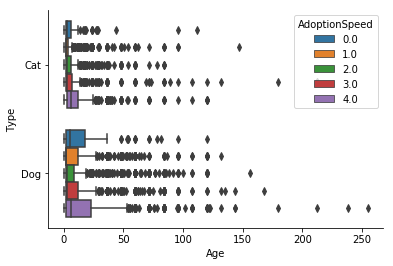

In [0]:
sns.boxplot(data=df_full,y='Type', x='Age', hue='AdoptionSpeed')
sns.despine()

Dado que el gráfico anterior posee bastantes outliers veamos  si podemos visualizar esto de otra manera.

In [0]:
dtas = df_full.groupby(['AdoptionSpeed'])['Type'].value_counts(normalize=True).rename('porcentaje').reset_index()
dtas

,AdoptionSpeed,Type,porcentaje
0,0.0,Cat,0.575439
1,0.0,Dog,0.424561
2,1.0,Cat,0.531925
3,1.0,Dog,0.468075
4,2.0,Dog,0.531975
5,2.0,Cat,0.468025
6,3.0,Dog,0.598268
7,3.0,Cat,0.401732
8,4.0,Dog,0.585020
9,4.0,Cat,0.414980


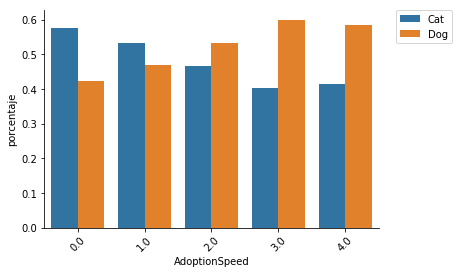

In [0]:
sns.barplot(x='AdoptionSpeed',y='porcentaje', data=dtas, hue='Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

Planteamos también la posibilidad que debido a la proximidad  entre ciudades, ya sea por regiones o por densidad demográficas , la velocidad de adopción presente comportamientos similares. 


In [0]:
df_full['State'].groupby([df_full['State']]).agg({'count'})

,count
State,
41324,137
41325,110
41326,8714
41327,843
41330,420
41332,253
41335,85
41336,507
41342,13


Analizamos las hipótesis en base a los estados:

* Mayor densidad poblacional y mayor cantidad de perros en adopción que gatos. Se espera menor cantidad de animales en la última etapa de adopción.  

   La mayoría de los datos proviene de los Estados 41326 y 41401, que son Selangor que es el estado mas poblado de Malasia y Kuala Lumpur que es la capital.  Johor (41336) al ser un estado muy grande, se espera como en Selangor y Kuala Lumpur, mayor conciencia de adopción y esterilización. 
  
   Pulau Pinang (41327) es la segunda provincia mas pequeña de Malasia pero con una alta densidad poblacional. Es la 3era en cantidad de animales en adopción (843). La siguen Negeri Sembilan  (41332) y  Melaka (41324) con 253 y 137 animales en adopción respectivamente. 
 Tienen una alta densidad demográfica y se encuentran muy cercanas a Perak (41330 el 2do estado mayor de Malasia peninsular, con  420 animales en adopción). 
 
   
 \\

* Menor densidad poblacional y  mayor cantidad de gatos en adopción que perros. 

  La hipótesis es que en pequeñas ciudades (o de menor densidad demográfica) hay menor conciencia de adopción y esterilización, por lo que se espera que haya mayor densidad de gatos en adopción. Se espera que haya muchos animales jóvenes, los cuales se adoptan mas rápidamente, pero a su vez, también se espera mayor cantidad de animales en la última etapa de adopción: 
  
 Los estados con menos datos,  Pahang (41335) ,   Kelantan (41367) ,  Terengganu  (41361) y Labuan (41415)  también tienen pocos habitantes y si bien hay menor cantidad de de animales disponibles es esperable que cueste conseguir familias para los mismos.

  Sarawak  (41342)  y  Sabah (41345) si bien son los estados mas grandes de Malasia Oriental, pero con densidad demográfica baja.  Poseen pocos animales en la base de datos,  en su mayoría: gatos

 

\\
Las excepciones a estas hipótesis son Kuala Lumpur (41401) en la cual hay mas gatos que perros en adopción (quizás porque se trata específicamente de una ciudad) y el estado de  Melaka(41324)  tampoco se cumple que haya pocos animales en la última etapa y hay una mayor densidad de perros que de gatos.  


Normalizando:

In [0]:
ds = df_full.groupby(['State'])['Type'].value_counts(normalize=True).rename('porcentaje').reset_index()

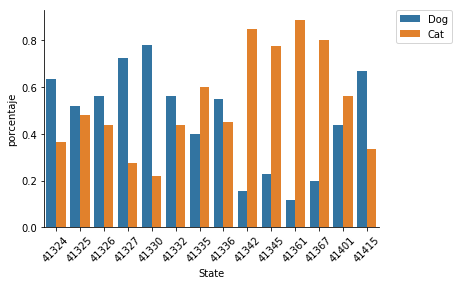

In [0]:
sns.barplot(x="State",y='porcentaje', data=ds, hue='Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()  

In [0]:
dsas = df_full.groupby(['State'])['AdoptionSpeed'].value_counts(normalize=True).rename('porcentaje').reset_index()
#dsas

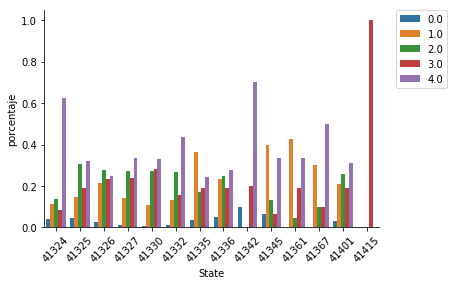

In [0]:
sns.barplot(x="State",y='porcentaje', data=dsas, hue='AdoptionSpeed')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

Otra de las hipótesis es que aquellos animales de color negros en su totalidad, son muchos mas y tienen menos chances de ser adoptados, mientras que aquellos de colores claros, tienen mas chances. Esto es un escenario mas desfavorable para los perros que para los gatos.

In [0]:
df_full['Color1'].value_counts(normalize=True)

Black     0.495365
Brown     0.250117
Golden    0.063163
Cream     0.058961
Gray      0.045621
White     0.044487
Yellow    0.042286
Name: Color1, dtype: float64

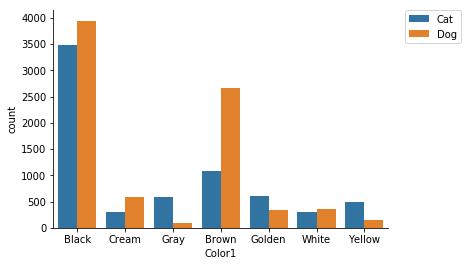

In [0]:
sns.countplot(df_full['Color1'], hue=df_full['Type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

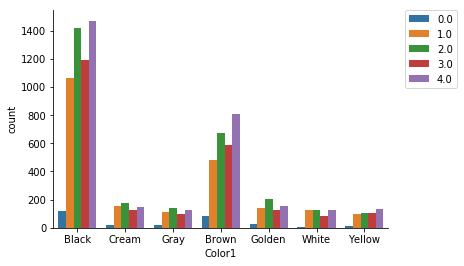

In [0]:
sns.countplot(df_full['Color1'], hue=df_full['AdoptionSpeed'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

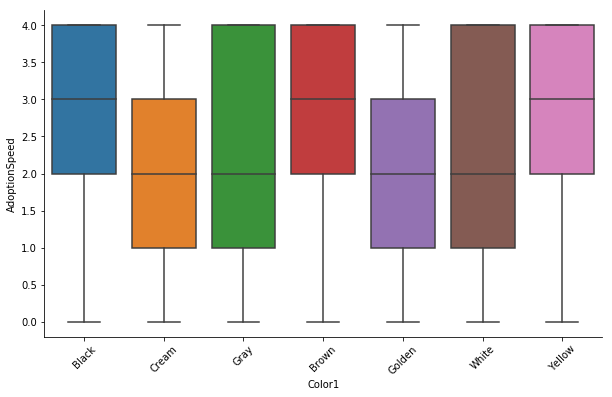

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_full,
                x='Color1', y='AdoptionSpeed')#, hue='Type')
plt.xticks(rotation=45)
sns.despine()

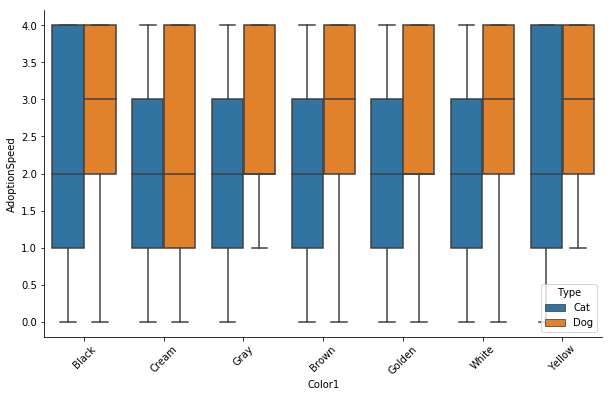

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_full,
                x='Color1', y='AdoptionSpeed', hue='Type')
plt.xticks(rotation=45)
sns.despine()

## Modelos planteados inicialmente

A continuación mostramos los modelos que fueron probados usando GridSearch. Es importante mencionar que los resultados son mostrados usando la mejor selección de features que devolvió gridsearch.

* ### Naive Bayes: 


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

mnb = GaussianNB()
mnb.fit(X_train.drop(["PID"], axis=1), y_train)
GaussianNB(priors=None, var_smoothing=1e-09)
y_pred = mnb.predict(X_valid.drop(["PID"], axis=1))
print("Accuracy:",accuracy_score(y_valid, y_pred))

Accuracy: 0.05762871988663203


* ### SGDClassifier

Clasificadores lineales con descenso del gradiente estocástico (SGD)

La función de costo ‘hinge’ se corresponde con el  clasificador linear SVM (Support Vector Machine ).

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


results = pd.DataFrame(columns=('clf', 'best_acc'))
from sklearn.linear_model import SGDClassifier

exploring_params = {
        'loss':['hinge'],
        'learning_rate': ['adaptive'],
        'eta0': [0.01],  
        'alpha': [ 0.01],
        'penalty': ['l1'],
        }

m = SGDClassifier(tol=1e-3,random_state=42,n_jobs=-1)
model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy',iid=False)
model.fit(X_train.drop(["PID"], axis=1), y_train)

best_model = model.best_estimator_
print('Best Decision Model accuracy: ', model.best_score_)
print(best_model)
results = results.append({'clf': best_model, 'best_acc': model.best_score_}, ignore_index=True)


Best Decision Model accuracy:  0.3085683559049253
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


La función de costo  ‘log’  realiza la clasificación por regresión logística.

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


results = pd.DataFrame(columns=('clf', 'best_acc'))
from sklearn.linear_model import SGDClassifier

exploring_params = {
        'loss':['log'],
        'learning_rate': ['adaptive'],
        'eta0': [ 0.01],  
        'alpha': [0.01],
        'penalty': ['elasticnet'],
        }

m = SGDClassifier(tol=1e-3,random_state=42,n_jobs=-1)
model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy',iid=False)
model.fit(X_train.drop(["PID"], axis=1), y_train)

best_model = model.best_estimator_
print('Best Decision Model accuracy: ', model.best_score_)
print(best_model)
results = results.append({'clf': best_model, 'best_acc': model.best_score_}, ignore_index=True)

Best Decision Model accuracy:  0.35168175174188576
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


 ‘perceptron’ es la función de costo utilizada por el algoritmo perceptrón:

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


results = pd.DataFrame(columns=('clf', 'best_acc'))
from sklearn.linear_model import SGDClassifier

exploring_params = {
        'loss':['perceptron'],
        'learning_rate': ['adaptive'],
        'eta0': [0.01],  
        'alpha': [ 0.01],
        'penalty': ['l1'],
        }

m = SGDClassifier(tol=1e-3,random_state=42,n_jobs=-1)
model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy',iid=False)
model.fit(X_train.drop(["PID"], axis=1), y_train)

best_model = model.best_estimator_
print('Best Decision Model accuracy: ', model.best_score_)
print(best_model)
results = results.append({'clf': best_model, 'best_acc': model.best_score_}, ignore_index=True)

Best Decision Model accuracy:  0.07719918876928797
SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


**DecisionTree**

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)


results = pd.DataFrame(columns=('clf', 'best_acc'))

tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 3,4,5,6,10),
              'min_samples_split':(2, 3, 5, 10, 50, 100)}
tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(X_train.drop(["PID"], axis=1), y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)


Best Decision Tree accuracy:  0.3632452840337382
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


### Random forest

In [0]:
results = pd.DataFrame(columns=('clf', 'best_acc'))
tree = RF(random_state=42)
tree_param = {'n_estimators':[80],
              'criterion': ['entropy'],
              'max_depth': [10],
              'min_samples_split': [5],
              'min_samples_leaf': [1],
              'max_leaf_nodes': [70],
              'max_features':[30],
              'n_jobs':[-1]
                }
tree = RF(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=3, iid=False)
tree_clf.fit(X_train.drop(["PID"], axis=1), y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)



Best Decision Tree accuracy:  0.3783646247310148
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=30, max_leaf_nodes=70,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


De los modelos probados inicialmente RandomForest devolvió el mejor acurracy (0.3783).

## Limpieza de datos

En las siguientes secciones se definen los métodos de normalizacion, tranformacion de datos, balanceo de clases y selección de feautures. Dependiendo el caso, si aplicará a los datos cada uno de estos métodos.

### Funcion de Normalizacion

In [2]:
def normalizar(df, scaler):
    fields = ['Fee','Age','Quantity']
    for col in fields:
        df[col] = scaler.fit_transform(df[[col]])
    return df

### Transformacion de Datos

In [3]:
def transform_data(train_data_fname, test_data_fname, normalized=True, convert_dummy=True):
    def transform_columns(df):
        breed = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/breed_labels.csv')
        color = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/color_labels.csv')
        state = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/state_labels.csv')
        state_dict = {}
        for index, row in state.iterrows():
            state_dict[row['StateID']] = row['StateName']
        df = df.drop(["Description"], axis=1)
        df.Type = df.Type.replace({1: 'Dog', 2: 'Cat'})
        df.Gender = df.Gender.replace({1:'Male', 2:'Female', 3:'Mixed'})
        df.MaturitySize = df.MaturitySize.replace({1:'S', 2:'M', 3:'L', 4:'XL', 0:'N/A'})
        df.FurLength = df.FurLength.replace({1:'S', 2:'M', 3:'L', 0:'N/A'})
        df.Vaccinated = df.Vaccinated.replace({1:'T', 2:'N', 3:'N/A'})
        df.Dewormed = df.Dewormed.replace({1:'T', 2:'F', 3:'N/A'})
        df.Sterilized = df.Sterilized.replace({1:'T', 2:'F', 3:'N/A'})
        df.State = df.State.replace(state_dict)
        df.Health = df.Health.replace({1:'Healthy', 2: 'MinorInjury', 3:'SeriousInjury', 0: 'N/A'})
        df.Color1 = df.Color1.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color2 = df.Color2.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Color3 = df.Color3.replace(dict(list(zip(color.ColorID, color.ColorName)) + [(0, "N/A")]))
        df.Breed1 = df.Breed1.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        df.Breed2 = df.Breed2.replace(dict(list(zip(breed.BreedID, breed.BreedName)) + [(0, "N/A")]))
        return df
    
    df_train = pd.read_csv(train_data_fname)
    df_train = transform_columns(df_train)
    df_test = pd.read_csv(test_data_fname)
    df_test = transform_columns(df_test)
    
    df = pd.concat([df_train, df_test], sort=True)

    # set dummy variables for everything
    # except from Age, Quantity, Fee
    if convert_dummy:
        df = pd.get_dummies(df)
        print("Dataset converted to dummies")
    if normalized:
        df = normalizar(df,MinMaxScaler())
        print("Dataset normalized")
    
    # get train and test back
    
    print("Returning train and test dataset")
    n = len(df_train)
    df_train = df.iloc[:n]
    df_test = df.iloc[n:]

    y = df_train['AdoptionSpeed']
    X = df_train.drop('AdoptionSpeed', axis=1)
    yy = None
    XX = df_test.drop('AdoptionSpeed', axis=1)

    return X, y, XX, yy


### Balanceo de clases

In [6]:
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter
def balance_class(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return pd.DataFrame(data=X_res[0:], columns=X.columns), pd.DataFrame(data=y_res, columns=['Target'])




Using TensorFlow backend.


### Preparacion de datos

In [10]:
X, y, XX, yy = transform_data("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv", "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")
x_tr, y_tr = balance_class(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)


Dataset converted to dummies
Dataset normalized
Returning train and test dataset
Resampled dataset shape Counter({2.0: 2964, 1.0: 2964, 4.0: 2964, 3.0: 2964, 0.0: 2964})


### Seleccion de Feature

In [11]:
from sklearn.feature_selection import SelectKBest

def select_best_feature(X, y, feature_number):
    best=SelectKBest(k=feature_number)
    X_new = best.fit_transform(X, y)
    X_new.shape
    selected = best.get_support(indices=True)
    print(X.columns[selected])
    used_features =X.columns[selected]

    colormap = plt.cm.viridis
    plt.figure(figsize=(12,6))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(X[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
    
    return used_features

### KNN

#### KNN con ajuste por parametro por defecto con datos balanceados y normalizados

In [0]:
neigh = KNeighborsClassifier()
neigh.fit(X_train.drop(["PID"], axis=1), y_train)
y_predict = neigh.predict(X_valid.drop(["PID"], axis=1))

#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid, y_predict))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy: 0.4409581646423752


#### KNN con mejor ajuste de hiperparametros con datos balanceados 

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


# Exploración de hiperparámetros para función de coste 

Mejor conjunto de parámetros:
{'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       578
         1.0       0.44      0.43      0.43       569
         2.0       0.33      0.36      0.34       585
         3.0       0.44      0.38      0.41       611
         4.0       0.42      0.39      0.41       621

    accuracy                           0.50      2964
   macro avg       0.49      0.50      0.50      2964
weighted avg       0.49      0.50      0.49      2964


Accuracy: 0.4997



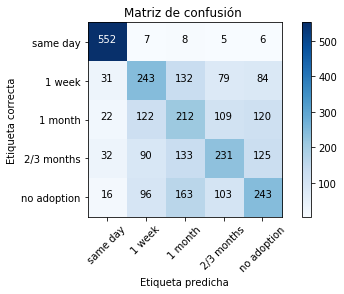

In [0]:
neigh_param = {'n_neighbors':[5],
              'weights':[ 'distance'],
              'algorithm':['auto'],
              'leaf_size': [15],
              'p':[1],
              'metric':['manhattan']
              }
neigh = KNeighborsClassifier()
neigh_clf = GridSearchCV(neigh, neigh_param, 
                         scoring='accuracy', 
                         verbose=1,
                         n_jobs=-1,
                         cv=3)
neigh_clf.fit(X_train.drop(["PID"], axis=1), y_train)

print("# Exploración de hiperparámetros para función de coste ", end="\n\n")
    
print("Mejor conjunto de parámetros:")
print(neigh_clf.best_params_, end="\n\n")

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_valid, neigh_clf.predict(X_valid.drop(["PID"], axis=1))
print(classification_report(y_true, y_pred), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")

#### Analisis de resultados



Dado que la mayoría de los datos de la clase 0 son producto del upsampling, la precisión de 0.85 para dicha clase es capcioso. Y esto también se ve reflejado en el accuracy. Da la sensación que estamos overfittiando los casos de la clase 0 para el conjunto de train y test. En las clases 1, 2, 3 y 4 (casos que no tuvo tanto upsampling), la precisión es bastante pareja.

Se realiza el mismo modelo pero con las clases sin balancear.

#### KNN normalizado sin balance de clases

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   47.9s finished


# Exploración de hiperparámetros para función de coste 

Mejor conjunto de parámetros:
{'algorithm': 'brute', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        61
         1.0       0.29      0.26      0.27       440
         2.0       0.30      0.42      0.35       557
         3.0       0.30      0.20      0.24       467
         4.0       0.42      0.47      0.44       592

    accuracy                           0.34      2117
   macro avg       0.26      0.27      0.26      2117
weighted avg       0.32      0.34      0.33      2117


Accuracy: 0.3368



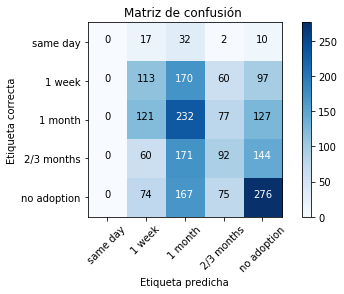

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

neigh_param = {'n_neighbors':[30],
              'weights':[ 'uniform'],
              'algorithm':['auto','brute'],
              'leaf_size': [15],
              'p':[1],
              'metric':['euclidean']
              }
neigh = KNeighborsClassifier()
neigh_clf = GridSearchCV(neigh, neigh_param, 
                         scoring='accuracy', 
                         verbose=1,
                         n_jobs=-1,
                         cv=3)
neigh_clf.fit(X_train.drop(["PID"], axis=1), y_train)

print("# Exploración de hiperparámetros para función de coste ", end="\n\n")
    
print("Mejor conjunto de parámetros:")
print(neigh_clf.best_params_, end="\n\n")

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_valid, neigh_clf.predict(X_valid.drop(["PID"], axis=1))
print(classification_report(y_true, y_pred), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")

#### Análisis de datos

Sin entrenamos el modelo con los datos sin balancear, podemos observar que al clasificador no consigue detectar a los que pertenecen a la clase cuya velocidad de adopción es el mismo dia. Por lo tanto es descartado.

#### KNN con seleccion de features y parámetros por defecto

Dataset converted to dummies
Dataset normalized
Returning train and test dataset
Resampled dataset shape Counter({2.0: 2964, 1.0: 2964, 4.0: 2964, 3.0: 2964, 0.0: 2964})
Index(['Breed1_Mixed Breed', 'Breed2_N/A', 'FurLength_L', 'FurLength_S',
       'MaturitySize_M', 'Sterilized_F', 'Sterilized_T', 'Type_Cat'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  7  21  62  73 108 118 122 123 127 135 154 171 181 182 190 197 209 224
 238 248 261 265 270 273 278 279 282 283 287 291 296 311] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


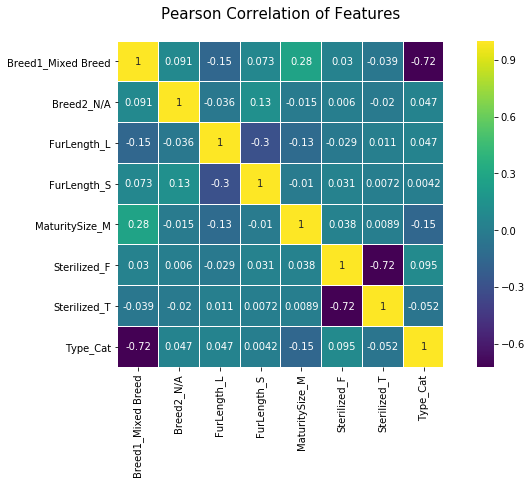

In [0]:
X, y, XX, yy = transform_data("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv", "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")
x_tr, y_tr = balance_class(X, y)

used_features = select_best_feature(x_tr.drop(["PID"], axis=1),y_tr,8)

X_train, X_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


# Exploración de hiperparámetros para función de coste 

Mejor conjunto de parámetros:
{}

Puntajes de la grilla:

Exactitud: 0.360 (+/-0.000) para los parámetros {}
Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71       578
         1.0       0.25      0.25      0.25       569
         2.0       0.28      0.43      0.34       585
         3.0       0.24      0.17      0.20       611
         4.0       0.45      0.29      0.35       621

    accuracy                           0.37      2964
   macro avg       0.38      0.38      0.37      2964
weighted avg       0.38      0.37      0.37      2964


Accuracy: 0.3745



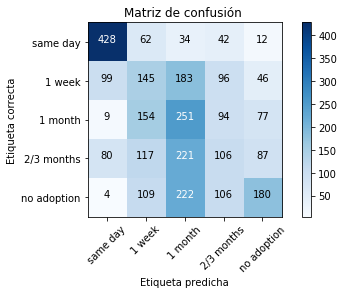

In [0]:
'''neigh_param = {'n_neighbors':[5,10,20,30],
              'weights':['uniform', 'distance'],
              'algorithm':['auto','brute'],
              'leaf_size': [15,30,45,90],
              'p':[1,2,4],
              'metric':['euclidean','manhattan']
              }
'''
neigh_param = {}
neigh = KNeighborsClassifier()
neigh_clf = GridSearchCV(neigh, neigh_param, 
                         scoring='accuracy', 
                         verbose=1,
                         n_jobs=-1,
                         cv=3)
neigh_clf.fit(X_train[used_features], y_train)

print("# Exploración de hiperparámetros para función de coste ", end="\n\n")
    
print("Mejor conjunto de parámetros:")
print(neigh_clf.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = neigh_clf.cv_results_['mean_test_score']
stds = neigh_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, neigh_clf.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))


print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_valid, neigh_clf.predict(X_valid[used_features])
print(classification_report(y_true, y_pred), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")
 

#### KNN con seleccion de features 

Dataset converted to dummies
Dataset normalized
Returning train and test dataset
Resampled dataset shape Counter({2.0: 2964, 1.0: 2964, 4.0: 2964, 3.0: 2964, 0.0: 2964})
Index(['Breed1_Mixed Breed', 'Breed2_N/A', 'FurLength_L', 'FurLength_S',
       'MaturitySize_M', 'Sterilized_F', 'Sterilized_T', 'Type_Cat'],
      dtype='object')

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  7  21  62  73 108 118 122 123 127 135 154 171 181 182 190 197 209 224
 238 248 261 265 270 273 278 279 282 283 287 291 296 311] are constant.
  UserWarning)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


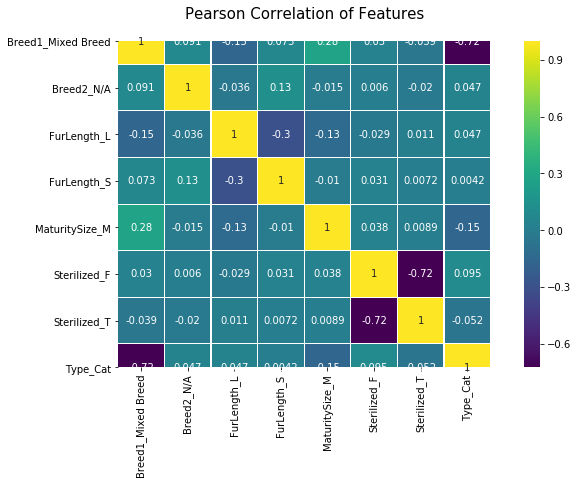

In [12]:
X, y, XX, yy = transform_data("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv", "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")
x_tr, y_tr = balance_class(X, y)

used_features = select_best_feature(x_tr.drop(["PID"], axis=1),y_tr,8)

X_train, X_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/m

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/users/slujan/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: 

# Exploración de hiperparámetros para función de coste 

Mejor conjunto de parámetros:
{'algorithm': 'auto', 'leaf_size': 90, 'metric': 'euclidean', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

Puntajes de la grilla:

Exactitud: 0.368 (+/-0.000) para los parámetros {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Exactitud: 0.366 (+/-0.000) para los parámetros {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Exactitud: 0.368 (+/-0.000) para los parámetros {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Exactitud: 0.366 (+/-0.000) para los parámetros {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Exactitud: 0.368 (+/-0.000) para los parámetros {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 4, 'weigh

              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70       578
         1.0       0.31      0.15      0.21       569
         2.0       0.27      0.29      0.28       585
         3.0       0.30      0.19      0.23       611
         4.0       0.32      0.57      0.41       621

    accuracy                           0.38      2964
   macro avg       0.38      0.38      0.36      2964
weighted avg       0.38      0.38      0.36      2964


Accuracy: 0.3779



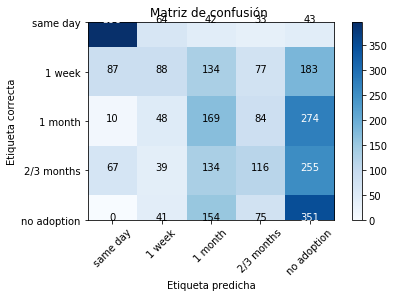

In [13]:
neigh_param = {'n_neighbors':[5,10,20,30],
              'weights':['uniform', 'distance'],
              'algorithm':['auto','brute'],
              'leaf_size': [15,30,45,90],
              'p':[1,2,4],
              'metric':['euclidean','manhattan']
              }

neigh = KNeighborsClassifier()
neigh_clf = GridSearchCV(neigh, neigh_param, 
                         scoring='accuracy', 
                         verbose=1,
                         n_jobs=-1,
                         cv=3)
neigh_clf.fit(X_train[used_features], y_train)

print("# Exploración de hiperparámetros para función de coste ", end="\n\n")
    
print("Mejor conjunto de parámetros:")
print(neigh_clf.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = neigh_clf.cv_results_['mean_test_score']
stds = neigh_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, neigh_clf.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))


print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_valid, neigh_clf.predict(X_valid[used_features])
print(classification_report(y_true, y_pred), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")

### Naive Bayes GaussianNB

#### Con parametros por defecto

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.22874493927125505
              precision    recall  f1-score   support

         0.0       0.21      1.00      0.35       578
         1.0       0.47      0.06      0.11       569
         2.0       0.34      0.02      0.04       585
         3.0       0.42      0.04      0.07       611
         4.0       0.29      0.05      0.09       621

    accuracy                           0.23      2964
   macro avg       0.35      0.23      0.13      2964
weighted avg       0.35      0.23      0.13      2964


Accuracy: 0.2287



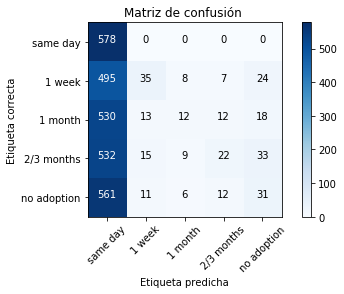

In [0]:
from sklearn.naive_bayes import GaussianNB

X_train, X_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)
clf = GaussianNB()
clf.fit(X_train.drop(["PID"], axis=1), y_train)
y_predict = clf.predict(X_valid.drop(["PID"], axis=1))

#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid, y_predict))

print(classification_report(y_valid, y_predict), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_valid, y_predict))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_valid, y_predict),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")

##### Analisis de resultados: 
El modelo esta detectando que la mayoria de los casos con adoption speed igual a same day. Por lo tanto es un mal clasificador. 

#### Realizamos seleccion de feature y aplicamos GaussianNB con parametros por defecto

Se selecciono 8 features debido a que obtenimos mejor performance para  dicha cantidad

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  7  21  62  73 108 118 122 123 127 135 154 171 181 182 190 197 209 224
 238 248 261 265 270 273 278 279 282 283 287 291 296 311] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['Breed1_Mixed Breed', 'Breed2_N/A', 'FurLength_L', 'FurLength_S',
       'MaturitySize_M', 'Sterilized_F', 'Sterilized_T', 'Type_Cat'],
      dtype='object')


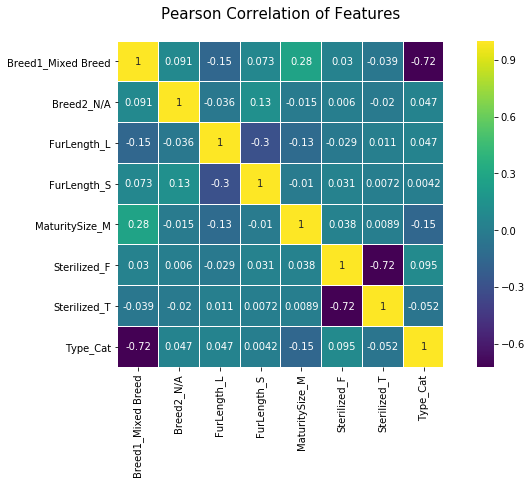

In [0]:
used_features = select_best_feature(x_tr.drop(["PID"], axis=1),y_tr,8)

X_train, X_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.43      0.48      0.45       578
         1.0       0.26      0.37      0.30       569
         2.0       0.29      0.12      0.17       585
         3.0       0.27      0.24      0.26       611
         4.0       0.36      0.42      0.39       621

    accuracy                           0.33      2964
   macro avg       0.32      0.33      0.31      2964
weighted avg       0.32      0.33      0.31      2964


Test Accuracy: 0.3252
Train Accuracy: 0.3222



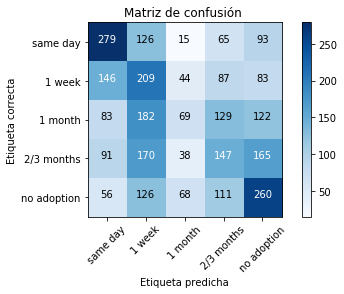

In [0]:
clf = GaussianNB()
clf.fit(X_train[used_features], y_train)
y_predict = clf.predict(X_valid[used_features])

#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy, how often is the classifier correct?

print(classification_report(y_valid, y_predict), end="\n\n")
print("Test Accuracy: %0.4f" % accuracy_score(y_valid, y_predict))
print("Train Accuracy: %0.4f" % accuracy_score(y_train, clf.predict(X_train[used_features])))
print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_valid, y_predict),
                      classes=('same day', '1 week', '1 month','2/3 months', 'no adoption'),title="Matriz de confusión ")

###### Analisis de resultados

Observamos que con seleccion de feature la detección de la clases se esparse más. La  performance mejora comparando el accuracy:

* Validation Accuracy: 0.3252
* Train Accuracy: 0.3222
*  Test accuracy ~0.25